In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import minerl
from tqdm import tqdm

from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utilities import flatten, unflatten, to_batch_shape, to_torch_channels

/home/marthinwurer/.pyenv/versions/3.9.6/envs/minerl/lib/python3.9/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [3]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 8]

In [ ]:
import autoencoder

In [5]:
# BATCH_SIZE = 512
BATCH_SIZE = 256
# BATCH_SIZE = 128
# BATCH_SIZE = 64
# BATCH_SIZE = 32
# BATCH_SIZE = 8
LEARNING_RATE = 0.0001
EPOCHS = 30
MOMENTUM = 0.9
# IN_POWER = 8
# IN_POWER = 6
in_dim = 64

In [6]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return eps * std + mu


def kld_loss(mu, log_var):
    kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim=0)
    return kld_loss

In [7]:
class VAELatent(nn.Module):
    def __init__(self, latent_size, input_size):
        super().__init__()
        self.mu = nn.Linear(input_size, latent_size)
        self.logvar = nn.Linear(input_size, latent_size)
    
    def forward(self, input):
        x = input
        x = torch.flatten(x, 1)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterize(mu, logvar)
        return (z, mu, logvar)

In [8]:
class WM_VAE(nn.Module):
    def __init__(self):
        super().__init__()
        activation = nn.ReLU
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2),
            activation(),
            nn.Conv2d(32, 64, 4, stride=2),
            activation(),
            nn.Conv2d(64, 128, 4, stride=2),
            activation(),
            nn.Conv2d(128, 256, 4, stride=2),
            activation(),
        )
        
        self.latent = VAELatent(128, 1024)
        
        self.unlatent = nn.Linear(128, 1024)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 128, 5, stride=2),
            activation(),
            nn.ConvTranspose2d(128, 64, 5, stride=2),
            activation(),
            nn.ConvTranspose2d(64, 32, 6, stride=2),
            activation(),
            nn.ConvTranspose2d(32, 3, 6, stride=2),
            nn.Sigmoid(),
        )
    
    def forward(self, input):
        encoded = self.encoder(input)
        latent = self.latent(encoded)
        x = self.unlatent(latent[0])
#         print(x.shape)
        x = unflatten(x)
#         print(x.shape)
        decoded = self.decoder(x)
#         print(decoded.shape)
        return decoded, latent

In [9]:
def vae_loss(inputs, outputs, latents):
    z, mu, logvar = latents
    recon = F.mse_loss(inputs, outputs)
    kl = kld_loss(mu, logvar) * .0
    return recon + kl, recon, kl

In [10]:
import shapes_dataset

In [11]:
shapes = shapes_dataset.build_shape_dataset(64, 64, 100000)

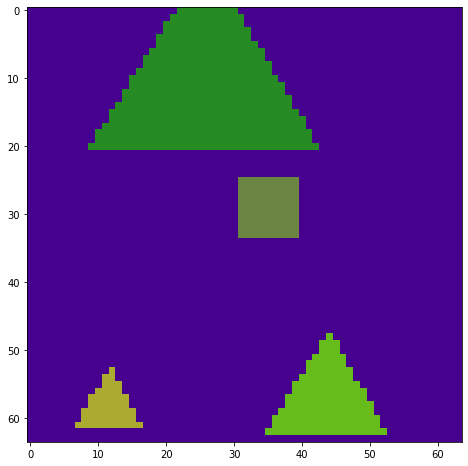

In [12]:
plt.imshow(shapes[2])

In [13]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [14]:
class ShapeDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image

In [15]:
sd = ShapeDataset(shapes)

In [16]:
train_dataloader = DataLoader(sd, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
train_features = next(iter(train_dataloader))

In [18]:
train_features.shape

torch.Size([256, 64, 64, 3])

In [19]:
shapes[0].shape

(64, 64, 3)

In [89]:
model = WM_VAE().cuda()
loss_func = vae_loss

In [90]:
# from AdvancedAutoencoder import AdvancedAutoencoder
# model = AdvancedAutoencoder().cuda()
# loss_func = autoencoder.mse_loss

In [91]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [92]:
from matplotlib.lines import Line2D
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())
            max_grads.append(p.grad.abs().max().cpu())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
#     plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])


In [93]:
def train_batch(inputs, model, optimizer, loss_func):
    # get the inputs
    inputs = inputs.cuda()

    if torch.isnan(inputs).any():
        print("There's a NaN input!")
        return None

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, latents = model(inputs)

    if torch.isnan(outputs).any():
        print("There's a NaN output!")
        return None
    loss = loss_func(inputs, outputs, latents)
    if isinstance(loss, tuple):
        loss[0].backward()
    else:
        loss.backward()
    
#     plot_grad_flow(model.named_parameters())

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    return loss

In [94]:
losses = []
raw_losses = []
recons = []
kls = []

In [97]:
running_loss = 0
loss_steps = 50
epochs = 500

for epoch in range(epochs):
    with tqdm(enumerate(train_dataloader, 0), unit="batch") as t:
        for i, data in t:
            # get the inputs
    #         current_state, action, reward, next_state, done = data
            image = data.transpose(-1, 1).cuda() / 255

    #         loss = train_batch(image, model, optimizer, autoencoder.spectral_loss)
            full_loss = train_batch(image, model, optimizer, loss_func)

            if isinstance(full_loss, tuple):
                loss = full_loss[0].item()
                raw_losses.append(loss)
                recons.append(full_loss[1].item())
                kls.append(full_loss[2].item())
            else:
                loss = full_loss.item()
                raw_losses.append(loss)


    #         if loss is None or torch.isnan(loss).any():
    #             print("There's a NaN loss!")
    #             from IPython.core.debugger import Pdb; Pdb().set_trace()
    #             break



            # print statistics
            running_loss += loss
            if i % loss_steps == loss_steps - 1:  # print every N mini-batches
                string = '[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / loss_steps)
                t.set_postfix_str(string)
                losses.append(running_loss / loss_steps)
    #             scheduler.step(running_loss)
                running_loss = 0.0

391batch [00:24, 15.76batch/s, [1,   350] loss: 0.00868971]
391batch [00:24, 15.64batch/s, [2,   350] loss: 0.00844086]
391batch [00:25, 15.60batch/s, [3,   350] loss: 0.00816132]
391batch [00:25, 15.55batch/s, [4,   350] loss: 0.00796414]
391batch [00:25, 15.52batch/s, [5,   350] loss: 0.00771201]
391batch [00:25, 15.52batch/s, [6,   350] loss: 0.00754162]
391batch [00:25, 15.51batch/s, [7,   350] loss: 0.00741237]
391batch [00:25, 15.49batch/s, [8,   350] loss: 0.00722544]
391batch [00:25, 15.48batch/s, [9,   350] loss: 0.00700231]
391batch [00:25, 15.47batch/s, [10,   350] loss: 0.00679718]
391batch [00:25, 15.46batch/s, [11,   350] loss: 0.00669575]
391batch [00:25, 15.47batch/s, [12,   350] loss: 0.00659784]
391batch [00:25, 15.48batch/s, [13,   350] loss: 0.00649811]
391batch [00:25, 15.46batch/s, [14,   350] loss: 0.00639752]
391batch [00:25, 15.49batch/s, [15,   350] loss: 0.00622210]
391batch [00:25, 15.47batch/s, [16,   350] loss: 0.00615100]
391batch [00:25, 15.48batch/s, [1

391batch [00:25, 15.43batch/s, [134,   350] loss: 0.00325101]
391batch [00:25, 15.42batch/s, [135,   350] loss: 0.00320918]
391batch [00:25, 15.42batch/s, [136,   350] loss: 0.00322786]
391batch [00:25, 15.42batch/s, [137,   350] loss: 0.00322430]
391batch [00:25, 15.47batch/s, [138,   350] loss: 0.00322052]
391batch [00:25, 15.43batch/s, [139,   350] loss: 0.00318922]
391batch [00:25, 15.43batch/s, [140,   350] loss: 0.00321526]
391batch [00:25, 15.43batch/s, [141,   350] loss: 0.00318529]
391batch [00:25, 15.42batch/s, [142,   350] loss: 0.00318530]
391batch [00:25, 15.38batch/s, [143,   350] loss: 0.00321045]
391batch [00:25, 15.42batch/s, [144,   350] loss: 0.00318806]
391batch [00:25, 15.42batch/s, [145,   350] loss: 0.00315399]
391batch [00:25, 15.42batch/s, [146,   350] loss: 0.00314543]
391batch [00:25, 15.43batch/s, [147,   350] loss: 0.00314515]
391batch [00:25, 15.44batch/s, [148,   350] loss: 0.00314080]
391batch [00:25, 15.44batch/s, [149,   350] loss: 0.00314219]
391batch

391batch [00:25, 15.41batch/s, [266,   350] loss: 0.00273579]
391batch [00:25, 15.42batch/s, [267,   350] loss: 0.00271040]
391batch [00:25, 15.43batch/s, [268,   350] loss: 0.00275149]
391batch [00:25, 15.42batch/s, [269,   350] loss: 0.00271947]
391batch [00:25, 15.42batch/s, [270,   350] loss: 0.00271427]
391batch [00:25, 15.42batch/s, [271,   350] loss: 0.00270560]
391batch [00:25, 15.43batch/s, [272,   350] loss: 0.00270230]
391batch [00:25, 15.42batch/s, [273,   350] loss: 0.00269628]
391batch [00:25, 15.42batch/s, [274,   350] loss: 0.00270713]
391batch [00:25, 15.41batch/s, [275,   350] loss: 0.00269935]
391batch [00:25, 15.44batch/s, [276,   350] loss: 0.00270889]
391batch [00:25, 15.46batch/s, [277,   350] loss: 0.00268504]
391batch [00:25, 15.45batch/s, [278,   350] loss: 0.00270337]
391batch [00:25, 15.43batch/s, [279,   350] loss: 0.00271640]
391batch [00:25, 15.44batch/s, [280,   350] loss: 0.00269463]
391batch [00:25, 15.43batch/s, [281,   350] loss: 0.00270004]
391batch

391batch [00:25, 15.45batch/s, [398,   350] loss: 0.00250876]
391batch [00:25, 15.45batch/s, [399,   350] loss: 0.00250804]
391batch [00:25, 15.45batch/s, [400,   350] loss: 0.00250649]
391batch [00:25, 15.45batch/s, [401,   350] loss: 0.00249862]
391batch [00:25, 15.44batch/s, [402,   350] loss: 0.00251473]
391batch [00:25, 15.44batch/s, [403,   350] loss: 0.00253218]
391batch [00:25, 15.40batch/s, [404,   350] loss: 0.00251109]
391batch [00:25, 15.44batch/s, [405,   350] loss: 0.00248232]
391batch [00:25, 15.43batch/s, [406,   350] loss: 0.00251739]
391batch [00:25, 15.43batch/s, [407,   350] loss: 0.00249637]
391batch [00:25, 15.44batch/s, [408,   350] loss: 0.00249147]
391batch [00:25, 15.41batch/s, [409,   350] loss: 0.00251023]
391batch [00:25, 15.44batch/s, [410,   350] loss: 0.00252821]
391batch [00:25, 15.44batch/s, [411,   350] loss: 0.00245474]
391batch [00:25, 15.45batch/s, [412,   350] loss: 0.00249979]
391batch [00:25, 15.46batch/s, [413,   350] loss: 0.00249133]
391batch

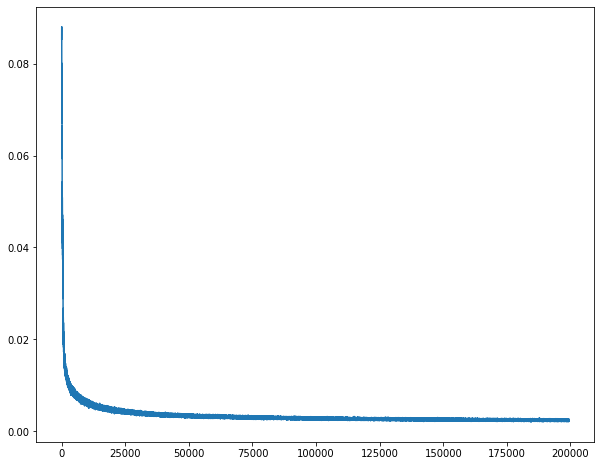

In [98]:
plt.plot(raw_losses)

In [197]:
kls[-1]

2.9857085337425815e-07

In [110]:
recon_target = shapes[3]
recon_target.shape

(64, 64, 3)

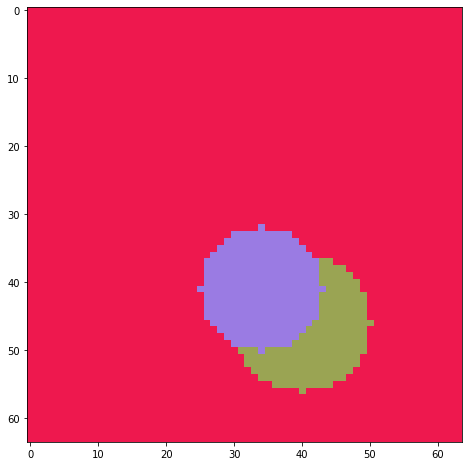

In [111]:
plt.imshow(recon_target)

In [112]:
image = torch.from_numpy(to_batch_shape(recon_target).transpose(0, 3, 1, 2)).cuda() / 255
image.shape

torch.Size([1, 3, 64, 64])

In [113]:
m2 = WM_VAE().cuda()

In [114]:
outputs, latents = model(image)
op = outputs.detach().cpu().numpy().transpose(0, 2, 3, 1)
op.shape

(1, 64, 64, 3)

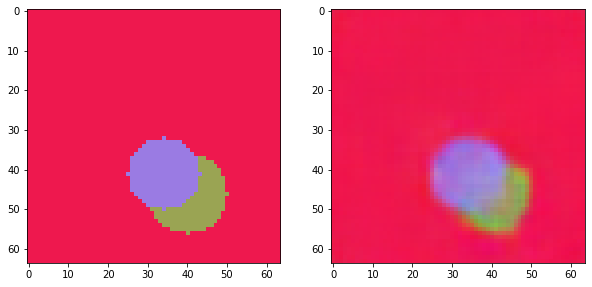

In [115]:
plt.subplot(1, 2, 1)
plt.imshow(recon_target)
plt.subplot(1, 2, 2)

plt.imshow(op[0])

In [73]:
image[0][0][0][0]

tensor(0.2706, device='cuda:0')

In [74]:
op[0][0][0][0]

0.4890771

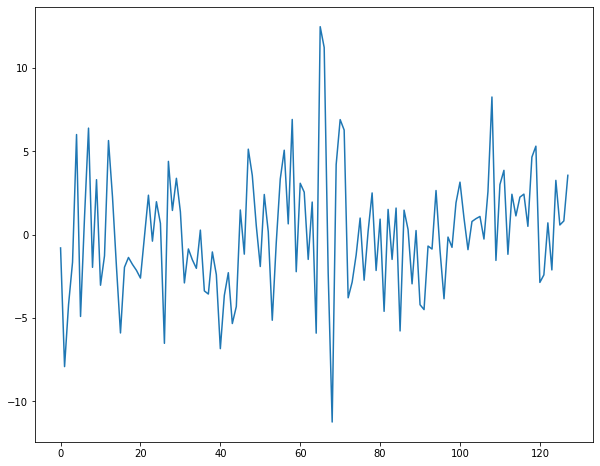

In [88]:
plt.plot(latents[0].detach().cpu().numpy())

In [64]:
latents[0].shape

torch.Size([1, 128])

In [105]:
from delve import CheckLayerSat
tracker = CheckLayerSat("my_experiment", save_to="plotcsv", modules=model, device=image.device)

added layer encoder-0
Skipping encoder-1
added layer encoder-2
Skipping encoder-3
added layer encoder-4
Skipping encoder-5
added layer encoder-6
Skipping encoder-7
added layer latent-mu
added layer latent-logvar
added layer unlatent
Skipping decoder-0
Skipping decoder-1
Skipping decoder-2
Skipping decoder-3
Skipping decoder-4
Skipping decoder-5
Skipping decoder-6
Skipping decoder-7


my_experiment_lsat_train_epoch_1.png


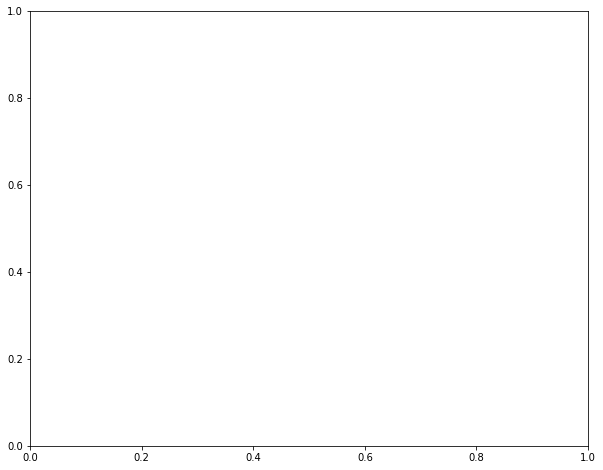

In [109]:
data = next(iter(train_dataloader))
image = data.transpose(-1, 1).cuda() / 255
outputs, latents = model(image)
tracker.add_saturations()